In [9]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import tensorflow as tf
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import copy
import numpy as np
import matplotlib.pyplot as plt

In [10]:

transform = transforms.ToTensor()

batch_size = 64

train_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_dataset_mnist = torch.utils.data.Subset(train_dataset_mnist,list(range(800)))

val_dataset_mnist = torch.utils.data.Subset(train_dataset_mnist,list(range(800, 1000)))


#train_dataset_mnist,val_dataset_mnist = random_split(train_dataset_mnist, [55000, 5000])
train_loader_mnist = torch.utils.data.DataLoader(train_dataset_mnist, batch_size=batch_size, shuffle=True)

val_loader_mnist = torch.utils.data.DataLoader(val_dataset_mnist, batch_size=batch_size, shuffle=True)
                                          
test_loader_mnist = torch.utils.data.DataLoader(test_dataset_mnist, batch_size=batch_size, shuffle=False)

X_temp, y_temp = next(iter(train_loader_mnist))

#print(X_temp[2], y_temp.shape)


In [11]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)
#    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [12]:
mb_size = 64
Z_dim = 100
X_dim = 28*28
h_dim = 128
c = 0
lr = 1e-3

In [13]:
Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z):
    h = F.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = torch.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X



In [14]:
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X):
    h = F.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = torch.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y




In [15]:
G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

In [16]:

def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mb_size, 1))
zeros_label = Variable(torch.zeros(mb_size, 1))

losses_g = []
losses_d = []
loss_g = 0
loss_d = 0
for it in range(100000): 
    # Sample data
    z = Variable(torch.randn(mb_size, Z_dim))
    X, _ = next(iter(train_loader_mnist))
    X = X.view(-1, 784)
    X = Variable(X)

    # Dicriminator forward-loss-backward-update
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    #D_loss_real = F.binary_cross_entropy(D_real, ones_label)
    #D_loss_fake = F.binary_cross_entropy(D_fake, zeros_label)
    #D_loss = D_loss_real + D_loss_fake

    D_loss = -torch.mean(torch.log(D_real) + torch.log(1. - D_fake))
    
    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    z = Variable(torch.randn(mb_size, Z_dim))
    G_sample = G(z)
    D_fake = D(G_sample)

    #G_loss = F.binary_cross_entropy(D_fake, ones_label)
    G_loss = -torch.mean(torch.log(D_fake))

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()
    loss_g += G_loss.data.numpy()
    loss_d += D_loss.data.numpy()
    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.numpy(), G_loss.data.numpy()), end='\r')
        if(it == 0):
            losses_g.append(D_loss.data.numpy())
            losses_d.append(G_loss.data.numpy())
        else:
            epoch_loss_g = loss_g / 10 # total generator loss for the epoch
            epoch_loss_d = loss_d / 10 # total discriminator loss for the epoch
            losses_g.append(epoch_loss_g)
            losses_d.append(epoch_loss_d)
        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('OutputsTask1/Ian100k/'):
            os.makedirs('OutputsTask1/Ian100k/')

        plt.savefig('OutputsTask1/Ian100k/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        c += 1
        plt.close(fig)
        loss_g = 0
        loss_d = 0
print('DONE TRAINING')

DONE TRAINING_loss: 0.006019765045493841; G_loss: 5.6739473342895518


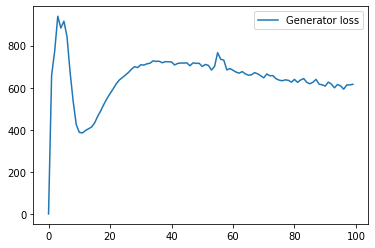

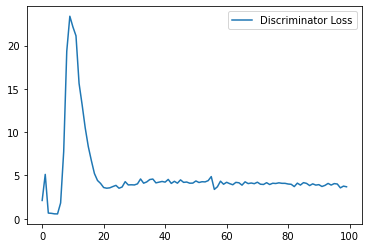

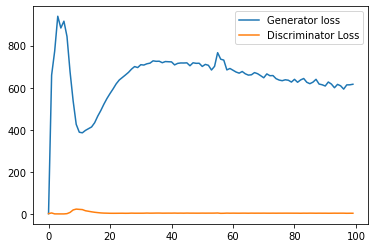

In [17]:
fi_los = [fl.item() for fl in losses_g ]
f2_los = [f2.item() for f2 in losses_d ]

plt.figure()
plt.plot(fi_los, label='Generator loss')
plt.legend()
plt.savefig('output/loss.png')

plt.figure()
plt.plot(f2_los, label='Discriminator Loss')
plt.legend()
plt.savefig('output/loss.png')

plt.figure()
plt.plot(fi_los, label='Generator loss')
plt.plot(f2_los, label='Discriminator Loss')
plt.legend()
plt.savefig('output/loss.png')
